# Layer 6 of the mesocircuit model

The mesocircuit model is a spatially organized spiking neuronal network model covering $4\times 4$ mm $^2$ with realistic neuron and synapse density.  The model is based on the cortical microcircuit by Potjans \& Diesmann (2014), in particular on an adapted version for macaque V1 as used in the multi-area model by Schmidt et al. (2018).

Senk, J., Hagen, E., van Albada, S. J., & Diesmann, M. (2018).  
*Reconciliation of weak pairwise spike-train correlations and highly coherent local field potentials across space.*  
https://doi.org/10.48550/ARXIV.1805.10235 and https://github.com/INM-6/mesocircuit-model

For demonstration purposes, we here only simulate one layer and downscale the number of neurons. We compensate for missing connections by adjusting the external input.

Johanna Senk  
EBRAINS Brain Simulation School 2023  
Training on modelling neurons, circuits, and cognitive functions  

Slightly modified for LASCON IX by Hans Ekkehard Plesser.

If you execute this notebook in the EBRAINS lab, choose the kernel $\texttt{EBRAINS-23.09}$. When you run it for the first time, you need to install the $\texttt{parameters}$ module by uncommenting the follownig line

In [1]:
!pip install parameters

In [2]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import nest
nest.set_verbosity('M_ERROR')


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.6.0
 Built: Oct 15 2023 14:47:07

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



Load the parameters of the mesocircuit model.

In [3]:
net_dict_filename = 'Lascon9_Reduced_Mesocircuit_net_dict.pkl'
with open(net_dict_filename, 'rb') as f:
    net_dict = pickle.load(f)

We first inspect the number of neurons in each population: L2/3E, L2/3I, L4E, L4I, L5E, L5I, L6E, L6I, TC. Beside the cortical layers, TC refers to a population of thalamocortical neurons which is used in the original model for external stimulation.


In [4]:
net_dict['num_neurons']

array([ 758176,  213856, 1126192,  281552,  331840,   72864,  317424,
         65008,   14432])

We specify a downscaling factor for the neuron numbers and compute the neuron numbers for our network that only contains populations L6E and L6I:

In [5]:
N_scaling = 0.045  # fits with a little margin on EBRAINS 2GB machines

N_L6E = np.round(net_dict['num_neurons'][6] * N_scaling).astype(int)
N_L6I = np.round(net_dict['num_neurons'][7] * N_scaling).astype(int)

N_L6E, N_L6I

(14284, 2925)

The neurons will be placed randomly (uniform distribution) in a square area of side length $\texttt{extent}$ (in mm):

In [6]:
extent = net_dict['extent']

extent

4.0

The neuron model used is a leaky integrate-and-fire model with exponential time course of the postsynaptic currents using the following parameters:

In [7]:
neuron_params = {
    # membrane capacitance (in pF)
    'C_m': 250.0,
    # membrane time constant (in ms)
    'tau_m': 10.0,    
    # resistive leak reversal potential (in mV)
    'E_L': -65.0,
    # spike detection threshold (in mV)
    'V_th': -50.0,
    # spike reset potential (in mV)
    'V_reset': -65.0,
    # refractory period after spikes (in ms)
    't_ref': 2.0,
    # time constants of postsynaptic currents (in ms)
    'tau_syn_ex': 2.0,
    'tau_syn_in': 8.0}

Next, we turn to the connectivity. The recurrent connections between all populations are here defined via a connection-specific in-degree, that is the number of source neurons from a source population that connect to one target neuron in the target population. The first index (rows) of the in-degree matrix corresponds to the target population and the second index (column) to the source population.  

In [8]:
net_dict['indegrees']

array([[1459,  573,  662,  253,  106,    0,   78,    0,    0],
       [1472,  419,  356,  144,  188,    0,   29,    0,    0],
       [ 105,   19,  753,  425,   23,    0,  445,    0,   92],
       [ 733,    9,  895,  834,    7,    0,  797,    0,   57],
       [1432,  201,  767,   18,  280,  227,  197,    0,    0],
       [ 580,   79,  289,    5,  149,  190,   65,    0,    0],
       [ 219,   22,  312,   51,  191,   12,  395,  296,   47],
       [ 377,    3,   33,    3,   69,    4,  367,  201,   18]])

We extract the in-degrees for our L6E-L6I subnetwork:

In [9]:
K_L6E_L6E = net_dict['indegrees'][6,6] # L6E -> L6E 
K_L6E_L6I = net_dict['indegrees'][7,6] # L6E -> L6I
K_L6I_L6E = net_dict['indegrees'][6,7] # L6I -> L6E
K_L6I_L6I = net_dict['indegrees'][7,7] # L6I -> L6I

print(K_L6E_L6E, K_L6E_L6I, K_L6I_L6E, K_L6I_L6I)

395 367 296 201


The connections will be drawn according to a spatial profile with exponential distance dependence. The decay constant $\texttt{beta}$ (in mm) depends on the connected populations:

In [10]:
beta_L6E_L6E = net_dict['beta'][6, 6] # L6E -> L6E
beta_L6E_L6I = net_dict['beta'][7, 6] # L6E -> L6I
beta_L6I_L6E = net_dict['beta'][6, 7] # L6I -> L6E
beta_L6I_L6I = net_dict['beta'][7, 7] # L6I -> L6I

print(beta_L6E_L6E, beta_L6E_L6I, beta_L6I_L6E, beta_L6I_L6I)

0.232 0.125 0.161 0.12


The maximum distance is defined via a mask radius that is proportional to beta. The mask scaling factor is chosen such that a deviation from the exponential profile is negligible:

In [11]:
mask_scaling = net_dict['mask_scaling']

mask_scaling

5.0

In addition to the recurrent connections, each neuron receives independent external Poisson spike input. The Poisson background rate (in spikes / s) is the same for all populations:

In [12]:
bg_rate = net_dict['bg_rate']

bg_rate

8.0

The external in-degree is different for each population. Note that it is only defined for the cortical populations:

In [13]:
net_dict['ext_indegrees']

array([1918, 1640, 1838, 3116, 1788, 1637, 1904, 1545])

Since we only want to simulate two out of eight cortical populations, we adjust the external in-degrees of L6E and L6I such that they also include a contribution from the missing recurrent connections. Here, we aim to preserve just the mean input (not the variance of the input). For this purpose, the firing rates from all cortical populations are required which have been obtained from a simulation of the full network:

In [14]:
rates_meso = np.array([0.372, 1.413, 1.199, 2.823, 2.281, 3.763, 1.132, 3.515])

We further need the weight matrix. In the original model, the weights (in pA) are normally distributed, but for the compensation we only consider the mean values:

In [15]:
net_dict['weight_matrix_mean']

array([[ 21.95212338, -60.3683393 ,  43.90424676, -60.3683393 ,
         21.95212338, -60.3683393 ,  21.95212338, -60.3683393 ,
         21.95212338],
       [ 21.95212338, -60.3683393 ,  21.95212338, -60.3683393 ,
         21.95212338, -60.3683393 ,  21.95212338, -60.3683393 ,
         21.95212338],
       [ 21.95212338, -60.3683393 ,  21.95212338, -60.3683393 ,
         21.95212338, -60.3683393 ,  21.95212338, -60.3683393 ,
         21.95212338],
       [ 21.95212338, -60.3683393 ,  21.95212338, -60.3683393 ,
         21.95212338, -60.3683393 ,  21.95212338, -60.3683393 ,
         21.95212338],
       [ 21.95212338, -60.3683393 ,  21.95212338, -60.3683393 ,
         21.95212338, -60.3683393 ,  21.95212338, -60.3683393 ,
         21.95212338],
       [ 21.95212338, -60.3683393 ,  21.95212338, -60.3683393 ,
         21.95212338, -60.3683393 ,  21.95212338, -60.3683393 ,
         21.95212338],
       [ 21.95212338, -60.3683393 ,  21.95212338, -60.3683393 ,
         21.95212338, -60.3683

Note that the weight from L4E to L2/3E is twice as large as the other excitatory weights. The external weight is equal to the default excitatory weight:

In [16]:
net_dict['weight_ext']

21.95212338230211

We next create an array with alternating excitatory and inhibitory synaptic time constants:

In [17]:
tau_syn = np.array([[neuron_params['tau_syn_ex'], neuron_params['tau_syn_in']] 
                    for i in np.arange(4)]).flatten()
tau_syn

array([2., 8., 2., 8., 2., 8., 2., 8.])

Now we can calculate the in-degree modifications for populations L6E (population index 6) and L6I (population index 7). The calculations here are based on the Brunel-ish expressions for mean and standard deviation of the rates

\begin{align}
    \newcommand{\tauM}{\tau_\text{m}}
\newcommand{\nuX}{\nu_\text{ext}}
  \mu_0 &= C_E J \tauM[\nuX + \nu_0(1-g\gamma)] \\[2ex]
  \sigma^2_0 &= C_E J^2 \tauM[\nuX + \nu_0(1-g^2\gamma)] 
                \end{align}

We focus on the mean rate. For problems of scaling network size, see

van Albada, S. J., Helias, M., & Diesmann, M. (2015).  
*Scalability of asynchronous networks is limited by one-to-one mapping between effective connectivity and correlations*.   
PLOS Computational Biology, 11(9), e1004490. https://doi.org/10.1371/journal.pcbi.1004490


In [18]:
included_popids = [6, 7] # L6E, L6I
indegree_modifications = np.zeros(len(included_popids))
excluded_popids = [0, 1, 2, 3, 4, 5] # L2/3E, L2/3I, L4E, L4I, L5E, L5I

for i, ipopid in enumerate(included_popids):
    weights_tau_syn_rec = net_dict['weight_matrix_mean'][ipopid][:-1] * tau_syn
    weight_tau_syn_ext = net_dict['weight_ext'] * neuron_params['tau_syn_ex']
    frac_weights_tau_syn = weights_tau_syn_rec / weight_tau_syn_ext

    frac_rates = rates_meso / net_dict['bg_rate']

    rec_input = frac_rates * frac_weights_tau_syn * net_dict['indegrees'][ipopid][:-1]

    for jpopid in [excluded_popids]:
        indegree_modifications[i] += np.sum(rec_input[jpopid])

The new external in-degrees of L6E and L6I are:

In [19]:
K_ext_L6E = np.round(net_dict['ext_indegrees'][6] + indegree_modifications[0]).astype(int)
K_ext_L6I = np.round(net_dict['ext_indegrees'][7] + indegree_modifications[1]).astype(int)

print('old:', net_dict['ext_indegrees'][6], net_dict['ext_indegrees'][7])
print('new:', K_ext_L6E, K_ext_L6I)

old: 1904 1545
new: 1713 1549


Now that the connectivity is defined, we can turn to the parameterization of the connections. Since our sub-network has only one excitatory and one inhibitory weight, we define its mean and standard deviation:

In [20]:
w_mean_ex = net_dict['weight_matrix_mean'][6, 6]
w_std_ex = w_mean_ex * net_dict['weight_rel_std']

w_mean_in = net_dict['weight_matrix_mean'][7, 7]
w_std_in = - w_mean_in * net_dict['weight_rel_std']

print(w_mean_ex, w_std_ex)
print(w_mean_in, w_std_in)

21.95212338230211 2.195212338230211
-60.3683393013308 6.0368339301330805


Recurrent connections in the model use a linear distance dependency and we assume that the delay offset (in ms) and the propagation speed (in mm / ms) are the same for all connections:

In [21]:
delay_offset = net_dict['delay_offset_exc_inh'][0]
prop_speed = net_dict['prop_speed_exc_inh'][0]

delay_offset, prop_speed

(0.5, 0.3)

The fixed delay (in ms) of the external Poisson input is:

In [22]:
delay_poisson = 1.0

Moreover, we specify whether a pertubation via the thalamocortical pathway shall be applied:

In [48]:
use_thalamic_pulse = False

Here, we do not explicitly make use of the thalamocortical populations as in the original model. Instead, we just apply a spike pulse to all neurons within a disk of a given radius in the center of the L6E population. We define this radius (in mm), the delay (in ms), the weight (in pA), and the time point (in ms) when the thalamic pulse shall be applied:

In [24]:
th_radius = 0.5
th_delay_pulse_generator = 1.0
th_weight = 50 * w_mean_ex
th_pulse_time = 500.

Having specified all network parameters, we start to set up the actual simulation with NEST. First, the simulation kernel needs to be reset:


In [25]:
nest.ResetKernel()

We set the seed for random number generation to get reproducible simulation results:

In [26]:
nest.rng_seed = 1234

We also specify the resolution of the simulation (that is a time step in ms): 

In [27]:
nest.resolution = 0.1

And we set the number of OpenMP threads to use. A good choice for the number of threads is the number of available compute cores:

In [28]:
nest.local_num_threads = os.cpu_count()
nest.local_num_threads

16

The positions of the neurons are defined in 2D space with periodic boundary conditions:

In [29]:
positions = nest.spatial.free(
    pos=nest.random.uniform(min=-extent / 2.,
                            max=extent / 2.),
    edge_wrap=True,
    extent=[extent, extent])

We create the excitatory and inhibitory neuron populations:

In [30]:
pop_L6E = nest.Create('iaf_psc_exp', N_L6E, params=neuron_params, positions=positions)
pop_L6I = nest.Create('iaf_psc_exp', N_L6I, params=neuron_params, positions=positions)

pop_L6E, pop_L6I

(NodeCollection(metadata=spatial, model=iaf_psc_exp, size=14284, first=1, last=14284),
 NodeCollection(metadata=spatial, model=iaf_psc_exp, size=2925, first=14285, last=17209))

Next, we define the synapse dictionaries containing the parameters of the excitatory and inhibitory connections:

In [31]:
syn_dict_ex = {
    'synapse_model': 'static_synapse',
    'weight': nest.math.redraw(
        nest.random.normal(
            mean=w_mean_ex,
            std=w_std_ex),
        min=0,
        max=np.Inf),
    'delay': nest.math.redraw(
        delay_offset + nest.spatial.distance / prop_speed, 
        min=nest.resolution - 0.5 * nest.resolution,
        max=np.Inf)
}

syn_dict_in = {
    'synapse_model': 'static_synapse',
    'weight': nest.math.redraw(
        nest.random.normal(
            mean=w_mean_in,
            std=w_std_in),
        min=-np.Inf,
        max=0),
    'delay': nest.math.redraw(
        delay_offset + nest.spatial.distance / prop_speed,
        min=nest.resolution - 0.5 * nest.resolution,
        max=np.Inf)
}

For the excitatory connections (from L6E), we define the connection dictionaries and then instantiate the connections:

In [32]:
# L6E -> L6E
conn_dict = {'rule': 'fixed_indegree',
             'indegree': K_L6E_L6E,
             'p': nest.spatial_distributions.exponential(
                x=nest.spatial.distance,
                beta=beta_L6E_L6E),
              'mask': {'circular': {
                'radius': beta_L6E_L6E * mask_scaling}}}
nest.Connect(pop_L6E, pop_L6E, conn_dict, syn_dict_ex)

# L6E -> L6I
conn_dict = {'rule': 'fixed_indegree',
             'indegree': K_L6E_L6I,
             'p': nest.spatial_distributions.exponential(
                x=nest.spatial.distance,
                beta=beta_L6E_L6I),
              'mask': {'circular': {
                'radius': beta_L6E_L6I * mask_scaling}}}
nest.Connect(pop_L6E, pop_L6I, conn_dict, syn_dict_ex)

Then we do the same for the inhibitory connections (from L6I):

In [33]:
# L6I -> L6E
conn_dict = {'rule': 'fixed_indegree',
             'indegree': K_L6I_L6E,
             'p': nest.spatial_distributions.exponential(
                x=nest.spatial.distance,
                beta=beta_L6I_L6E),
              'mask': {'circular': {
                'radius': beta_L6I_L6E * mask_scaling}}}
nest.Connect(pop_L6I, pop_L6E, conn_dict, syn_dict_in)

# L6I -> L6I
conn_dict = {'rule': 'fixed_indegree',
             'indegree': K_L6I_L6I,
             'p': nest.spatial_distributions.exponential(
                x=nest.spatial.distance,
                beta=beta_L6I_L6I),
              'mask': {'circular': {
                'radius': beta_L6I_L6I * mask_scaling}}}
nest.Connect(pop_L6I, pop_L6I, conn_dict, syn_dict_in)
     

The external Poisson generators are created and connected:

In [34]:
poisson_generator_L6E = nest.Create('poisson_generator',
                                    params={'rate': bg_rate * K_ext_L6E})
nest.Connect(poisson_generator_L6E, pop_L6E,
             'all_to_all',
             {'weight': w_mean_ex, 'delay': delay_poisson})

poisson_generator_L6I = nest.Create('poisson_generator',
                                    params={'rate': bg_rate * K_ext_L6I})
nest.Connect(poisson_generator_L6I, pop_L6I,
             'all_to_all',
             {'weight': w_mean_ex, 'delay': delay_poisson})

Each population gets a spike recorder:

In [35]:
sr_L6E = nest.Create('spike_recorder')
nest.Connect(pop_L6E, sr_L6E)

sr_L6I = nest.Create('spike_recorder')
nest.Connect(pop_L6I, sr_L6I)

If a thalamic pulse stimulus shall be applied, we here create a spike generator and connect it to all neurons in L6E inside a center disc of defined radius: 

In [36]:
if use_thalamic_pulse:
    spike_pulse_input_th = nest.Create('spike_generator',
                                       params={'spike_times': [th_pulse_time]},
                                       positions=nest.spatial.grid(
                                            shape=[1, 1],
                                            edge_wrap=True))
    
    conn_dict_pulse_th = {
                'rule': 'pairwise_bernoulli',
                'p': 1., 
                'mask': {'circular': {'radius': th_radius}}}
    
    syn_dict_pulse_th = {
                'weight': th_weight,
                'delay': th_delay_pulse_generator}

    nest.Connect(spike_pulse_input_th, pop_L6E,
                 conn_dict_pulse_th,
                 syn_dict_pulse_th)

We finally define the simulation duration (in ms) and run the network simulation:

In [37]:
t_sim = 1000.0
nest.Simulate(t_sim)

To inspect the spike data after the simulation has finished, we read out the recorded spikes from both spike recorders:

In [38]:
spike_senders_L6E = nest.GetStatus(sr_L6E)[0]['events']['senders']
spike_times_L6E = nest.GetStatus(sr_L6E)[0]['events']['times']
spike_senders_L6I = nest.GetStatus(sr_L6I)[0]['events']['senders']
spike_times_L6I = nest.GetStatus(sr_L6I)[0]['events']['times']

spike_senders_L6E[:20], spike_times_L6E[:20]

(array([ 3008, 12560,  1504,  2272,  3024,  3184,  3856,  5136,  5712,
         8160,  8768, 11776, 12944, 13584,   528,   720,  1968,  2896,
         3216,  3392]),
 array([10.8, 11.4, 11.9, 11.6, 12. , 11.7, 12. , 11.7, 11.8, 11.8, 11.6,
        11.8, 11.8, 11.8, 12.4, 12.3, 12.1, 12.5, 12.5, 12.1]))

For getting a first impression of the spike output, we stack the data from both populations:

In [39]:
spike_senders = np.hstack((spike_senders_L6E, spike_senders_L6I))
spike_times = np.hstack((spike_times_L6E, spike_times_L6I))

The raster plot shows the spikes of L6E at the bottom and of L6I on top:

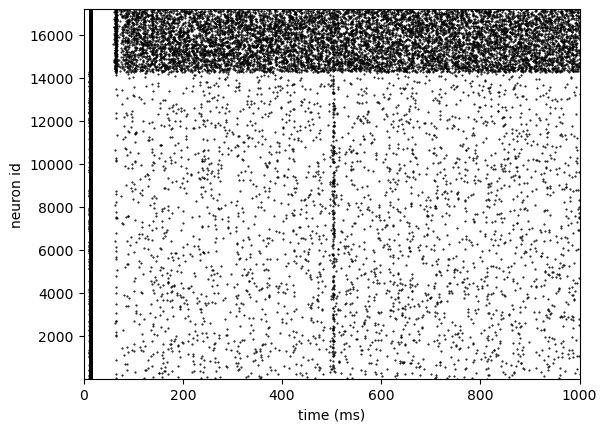

In [40]:
plt.plot(spike_times, spike_senders, 'k.', markersize=1)
plt.xlim(0, t_sim)
plt.ylim(1, N_L6E + N_L6I)
plt.xlabel('time (ms)')
plt.ylabel('neuron id');

We can also provide an estimate for the average per-neuron firing rates. To avoid a startup transient in the calculation, we discard the data in the beginning of the simulation:

In [41]:
t_transient = 100.0

spike_count_L6E = sum(t > t_transient for t in spike_times_L6E)
rate_L6E = spike_count_L6E / (t_sim - t_transient) * 1e3 / N_L6E
print(f'Firing rate L6E = {rate_L6E:.2f} spikes/s')

spike_count_L6I = sum(t > t_transient for t in spike_times_L6I)
rate_L6I = spike_count_L6I / (t_sim - t_transient) * 1e3 / N_L6I
print(f'Firing rate L6I = {rate_L6I:.2f} spikes/s')

Firing rate L6E = 0.24 spikes/s
Firing rate L6I = 3.58 spikes/s


Next, we retrieve the x-positions (in mm) of poth populations:

In [42]:
x_positions_L6E = np.array(pop_L6E.spatial['positions'])[:,0]
x_positions_L6I = np.array(pop_L6I.spatial['positions'])[:,0]

x_positions_L6E

array([ 1.93102897,  1.26678132,  0.019807  , ...,  1.90488168,
       -0.3420064 ,  0.9339744 ])

We use the x-positions to sort the senders:

In [43]:
spike_senders_pos_L6E = np.array([x_positions_L6E[nid-1] for nid in spike_senders_L6E])
spike_senders_pos_L6I = np.array([x_positions_L6I[nid-1-N_L6E] for nid in spike_senders_L6I])

We can finally create raster plots in which the vertical axis corresponds to the x-position instead of the neuron id:

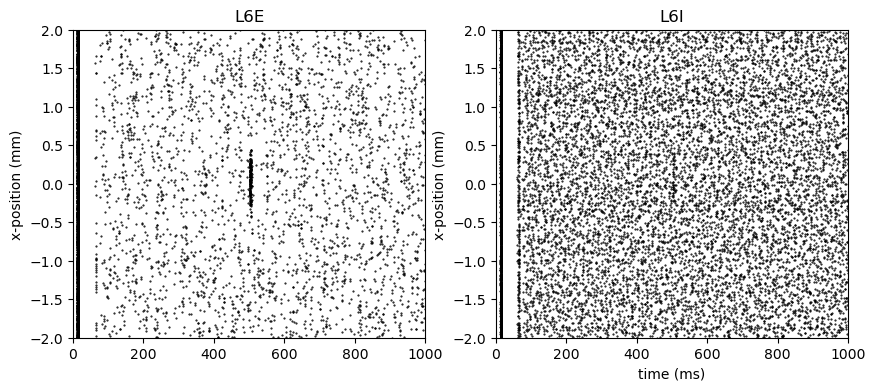

In [44]:
plt.figure(figsize=(10, 4))
ax = plt.subplot(1, 2, 1)
ax.set_title('L6E')
ax.plot(spike_times_L6E, spike_senders_pos_L6E, 'k.', markersize=1)
ax.set_xlim(0, t_sim)
ax.set_ylim(-extent/2, extent/2)
ax.set_ylabel('x-position (mm)')

ax = plt.subplot(1, 2, 2)
ax.set_title('L6I')
ax.plot(spike_times_L6I, spike_senders_pos_L6I, 'k.', markersize=1)
ax.set_xlim(0, t_sim)
ax.set_ylim(-extent/2, extent/2)
ax.set_xlabel('time (ms)')
ax.set_ylabel('x-position (mm)');

### Plot again with focusing at time around thalamic pulse injection

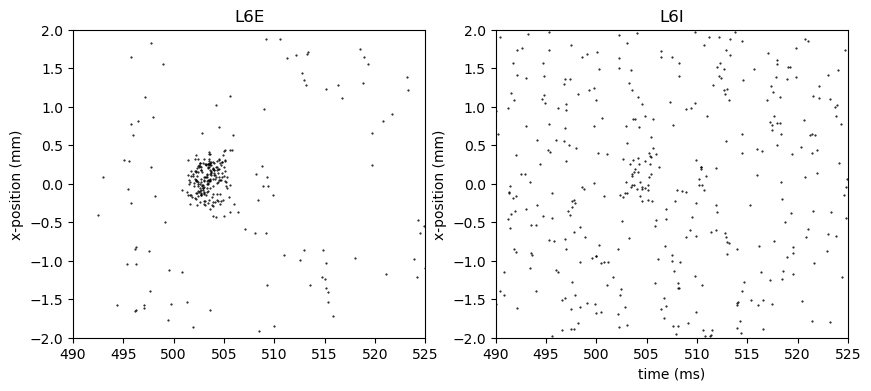

In [47]:
plt.figure(figsize=(10, 4))
ax = plt.subplot(1, 2, 1)
ax.set_title('L6E')
ax.plot(spike_times_L6E, spike_senders_pos_L6E, 'k.', markersize=1)
ax.set_xlim(th_pulse_time-10, th_pulse_time+25)
ax.set_ylim(-extent/2, extent/2)
ax.set_ylabel('x-position (mm)')

ax = plt.subplot(1, 2, 2)
ax.set_title('L6I')
ax.plot(spike_times_L6I, spike_senders_pos_L6I, 'k.', markersize=1)
ax.set_xlim(th_pulse_time-10, th_pulse_time+25)
ax.set_ylim(-extent/2, extent/2)
ax.set_xlabel('time (ms)')
ax.set_ylabel('x-position (mm)');